2023-02-01 최다희
# week5. Ensemble 과제

[주제]
감귤 착과량 예측 AI 모델 개발


[설명]
감귤나무의 나무 생육 상태, 엽록소 및 새순 정보로부터 감귤 착과량을 회귀 예측

https://dacon.io/competitions/official/236038/codeshare/7300?page=1&dtype=recent

In [7]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
import pandas
import numpy
import sklearn
import lightgbm

print('pandas Version :', pandas.__version__)
print('numpy Version :', numpy.__version__)
print('sklearn Version :', sklearn.__version__)
print('lightgbm Version :', lightgbm.__version__)

pandas Version : 1.2.3
numpy Version : 1.19.2
sklearn Version : 1.1.3
lightgbm Version : 3.2.1


 ## 앙상블 (Ensemble) 방법 ??
 머신 러닝에서 앙상블은 단어 그대로 여러 단순한 모델을 결합하여 정확한 모델을 만드는 방법이다. 강력한 성능에 비해 의외로 앙상블 방법의 개념은 매우 단순하다. 앙상블 개념의 핵심 개념은 다양한 종류의 여러 estimator를 결합하여 더 좋은 estimator를 만드는 것이다. 앙상블 방법의 종류는 estimator들을 어떻게 결합할 것인지에 의해 결정된다. 가장 단순한 앙상블 방법으로는 그림 2와 같이 투표를 기반으로 base estimator들을 결합하여 최종 estimator를 만드는 것이 있다.
 
 ---------------------------
 
### Model Architecture
#### Lightgbm with Permutations Importances and Seed Ensembles
 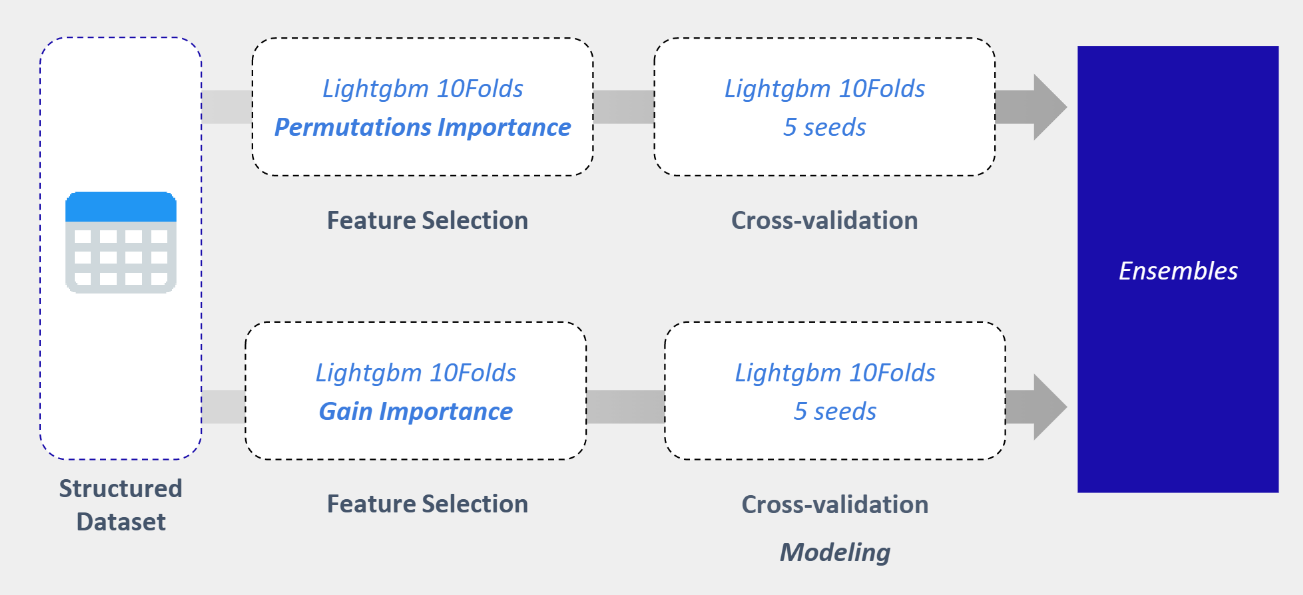
 
#### 1.  permutation importance ??
 
Permutation Importance는 기본적으로 제공되는 Feature Importance와 비슷한 기능을 한다. 기본적으로 제공되는 feature importance는 보통 가지에서 몇번 등장하는지, 혹은 불순도를 얼마나 낮추는 지에 대한 지표이다. 하지만 이 방법의 문제점은 -영향(negative)을 주는 feature를 알수 없다는 것이다. 즉, feature selection에서 가장 중요한 불필요한 feature를 빼는 과정에 있어서 크게 도움을 받을 수 없다. Permutation Importance는 모델을 학습시킨 뒤, 특정 feature의 데이터를 shuffle 했을 때, 검증 데이터 셋에 대한 예측성능을 확인하고 feature importance를 계산한다. 즉, shuffle 했을 때 모델의 성능이 떨어지면, 중요한 feature 인거고 성능이 그대로거나, 좋아지면 중요하지 않은 feature 이다.

#### 2. lgbm ??

 Light GBM(Light Gradient Boosting Machine)은 트리 기반의 학습 알고리즘인 gradient boosting 방식의 프레임워크이다. Light GBM은 다른 알고리즘이 트리를 수평으로 확장하는 것에 반해 트리를 수직으로 확장한다. 즉, 기존의 알고리즘은 수평으로 확장하여 포화 트리를 만들고(Level-wise tree growth), left-wise tree growth인 LGBM은 최대 delta loss가 증가하도록 잎의 개수를 정한다. 그렇기에 leaf-wise 알고리즘은 다른 level-wise 알고리즘보다 낮은 loss를 달성하는 경향이 있다. 데이터의 크기가 작은 경우 leaf-wise는 과적합(overfitting)이 되기 쉬우므로 max_depth를 줄여줘야 한다.
 
 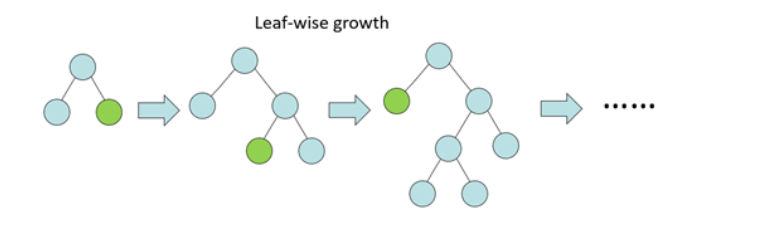
 
  Light GBM의 'Light'에 걸맞게 속도가 빠른 것이 굉장히 큰 장점이다. 또한, 메모리를 적게 차지하고 속도가 빠르다는 장점 외에도, LGBM은 결과의 정확도가 높다는 장점이 있고 GPU를 활용할 수 있기 때문에 널리 사용되고 있다. 하지만, 위에서 언급했듯이 overfitting에 민감하기에 데이터의 크기가 작을 경우 기존의 머신러닝 알고리즘이 더 좋을 수 있다. 데이터의 개수가 10,000개 이상일 때 좋다고 한다.

In [9]:
## ---------------------------------------------------------- 넘파이, 랜덤 시드고정
def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
## ----------------------------------------------------------  NMAE (Normalized Mean Absolute Error)는 
## --------------- 척도가 다른 데이터 세트의 MAE에 관한 비교를 용이하게 하기 위해서 정규화를 적용한 것
def nmae(true, pred):
    return mae(true, pred) / 406.22247394653374


def permutation_importances(model, vv):
    use_features = vv[0].columns
    oof = model.predict(vv[0])
    base_score = mae(vv[1], oof)

    good_features = []
    for col in use_features:
        test = vv[0].copy()
        test[col] = np.random.permutation(test[col])
        permu_oof = model.predict(test)
        permu_score = mae(vv[1], permu_oof)
        if permu_score > base_score:
            good_features += [col]
    return good_features

def main():
    
    df_train = pd.read_csv('train.csv') ## ---------------- 트레인데이터 로드
    df_test = pd.read_csv('test.csv') ## ------------------ 테스트데이터 로드
    sub = pd.read_csv('sample_submission.csv') ## --------- 서브밋파일로드
    target = '착과량(int)' ## ----------------------------- 타겟변수

    seed_permu_oof = []
    seed_permu_prediction = []
    seed_ff_oof = []
    seed_ff_prediction = []
    FOLDS = 10 ## ---------------------------------------- fold = 10
    SEEDS = [42, 1028, 1234, 0, 24] ## ------------------- 랜덤시드 차이에 따른 모델의 결과값을 앙상블하기 위해
    ## --------------------------------------------------- 5개의 시드를 리스트 형태로 저장해둠.
    
    for seed in SEEDS: ## ------------------------------- 저장한 5개 시드로 모델 돌림
        seed_everything(seed=seed)

        kf = KFold(n_splits=FOLDS, random_state=seed, shuffle=True)
        splits = list(kf.split(df_train)) ## ------------ data split

        drop_cols = ['ID']
        drop_cols += [col for col in df_train.columns if '새순' not in col]

        feature_importacne_df = pd.DataFrame() ## ------- feature importance 저장 프레임 생성
        use_cols = [col for col in df_train.columns if col not in drop_cols + [target]]
        oof = np.zeros(len(df_train))
        prediction = np.zeros(len(df_test))

        for fold, (trn_idx, val_idx) in enumerate(splits):
            print(f'-------------------------- {fold}/{FOLDS} --------------------------')
            tt = (df_train.loc[trn_idx, use_cols], df_train.loc[trn_idx, target])  ## train
            vv = (df_train.loc[val_idx, use_cols], df_train.loc[val_idx, target])  ## valid

            reg = LGBMRegressor(
                            objective='regression',
                            n_estimators=10000, ##  default는 100인데 1000정도는 해주는게 좋다고 한다. 너무 크게하면 과적합이 발생할 수 있다.
                            learning_rate=0.01, ## 일반적으로 0.01 ~ 0.1 정도로 맞추고 다른 파라미터를 튜닝한다. 나중에 성능을 더 높일 때 learning rate를 더 줄인다
                            max_depth=-1, ##  -1로 설정하면 제한없이 분기한다. feature가 많다면 크게 설정한다. 파라미터 설정 시 우선적으로 설정한다.
                            subsample=0.7,
                            colsample_bytree=0.3,
                            random_state=seed,
                            )
            
            reg.fit(tt[0], tt[1], eval_set=[tt, vv], early_stopping_rounds=200, verbose=500)

            permu_features = permutation_importances(reg, vv) ## ----------------------- permutation importance
            use_cols = permu_features ## ----------------------------------------------- 로 피처선택
            tt = (df_train.loc[trn_idx, use_cols], df_train.loc[trn_idx, target]) ## 선택된 피처로 새로 정의
            vv = (df_train.loc[val_idx, use_cols], df_train.loc[val_idx, target]) ## 선택된 피처로 새로 정의
            
            reg.fit(tt[0], tt[1], eval_set=[tt, vv], early_stopping_rounds=200, verbose=500) ## 모델 다시 핏 시킴

            oof[val_idx] = reg.predict(vv[0])
            prediction += reg.predict(df_test[use_cols]) / FOLDS
            feature_importacne_df = feature_importacne_df.append(pd.DataFrame(zip(use_cols, reg.feature_importances_), columns=['feature', 'value']))

        feature_importacne_df = feature_importacne_df.groupby('feature').mean().sort_values('value', ascending=False).reset_index()
        print(nmae(df_train[target], oof), mae(df_train[target], oof), mse(df_train[target], oof))
        seed_permu_oof += [oof]
        seed_permu_prediction += [prediction]

    
    for seed in SEEDS:
        seed_everything(seed=seed)

        kf = KFold(n_splits=FOLDS, random_state=seed, shuffle=True)
        splits = list(kf.split(df_train))

        drop_cols = ['ID']
        drop_cols += [col for col in df_train.columns if '새순' not in col]

        feature_importacne_df = pd.DataFrame()
        use_cols = [col for col in df_train.columns if col not in drop_cols + [target]]
        oof = np.zeros(len(df_train))
        prediction = np.zeros(len(df_test))

        for fold, (trn_idx, val_idx) in enumerate(splits):
            print(f'-------------------------- {fold}/{FOLDS} --------------------------')
            tt = (df_train.loc[trn_idx, use_cols], df_train.loc[trn_idx, target])
            vv = (df_train.loc[val_idx, use_cols], df_train.loc[val_idx, target])

            reg = LGBMRegressor(
                            objective='regression',
                            n_estimators=10000,
                            learning_rate=0.01,
                            max_depth=-1,
                            subsample=0.7,
                            colsample_bytree=0.3,
                            random_state=seed,
                            )
            reg.fit(tt[0], tt[1], eval_set=[tt, vv], early_stopping_rounds=200, verbose=500)

            oof[val_idx] = reg.predict(vv[0])
            prediction += reg.predict(df_test[use_cols]) / FOLDS
            feature_importacne_df = feature_importacne_df.append(pd.DataFrame(zip(use_cols, reg.feature_importances_), columns=['feature', 'value']))
        feature_importacne_df = feature_importacne_df.groupby('feature').mean().sort_values('value', ascending=False).reset_index()

        use_cols = feature_importacne_df.iloc[:20, 0].tolist()
        oof = np.zeros(len(df_train))
        prediction = np.zeros(len(df_test))
        
        # 피처임포턴스로 중요도 뽑아서 20개만 사용해서 다시 돌림
        for fold, (trn_idx, val_idx) in enumerate(splits):
            print(f'-------------------------- {fold}/{FOLDS} --------------------------')
            tt = (df_train.loc[trn_idx, use_cols], df_train.loc[trn_idx, target])
            vv = (df_train.loc[val_idx, use_cols], df_train.loc[val_idx, target])

            lr = LGBMRegressor(
                            objective='regression',# regression, regression_l1, poisson
                            n_estimators=10000,
                            learning_rate=0.01,
                            max_depth=-1,
                            subsample=0.7,
                            colsample_bytree=0.3,
                            random_state=seed,
                            )
            lr.fit(tt[0], tt[1], eval_set=[tt, vv], early_stopping_rounds=200, verbose=500)

            oof[val_idx] = lr.predict(vv[0])
            prediction += lr.predict(df_test[use_cols]) / FOLDS

        seed_ff_oof += [oof]
        seed_ff_prediction += [prediction]
        
    sub[target] = np.mean(seed_permu_prediction, 0)*0.5 + np.mean(seed_ff_prediction, 0)*0.5
    sub.to_csv('submission_tobigs.csv', index=False)


if __name__=='__main__':
    main()

-------------------------- 0/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 956.891	valid_1's l2: 1458.37
Early stopping, best iteration is:
[458]	training's l2: 979.741	valid_1's l2: 1454.61
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1039.88	valid_1's l2: 1423.78
Early stopping, best iteration is:
[475]	training's l2: 1049.84	valid_1's l2: 1422.59
-------------------------- 1/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1017.3	valid_1's l2: 1666.8
Early stopping, best iteration is:
[446]	training's l2: 1040.84	valid_1's l2: 1660.08
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1061.3	valid_1's l2: 1609.46
Early stopping, best iteration is:
[441]	training's l2: 1083.76	valid_1's l2: 1606.41
-------------------------- 2/10 --------------------------
Training until validation scor

[500]	training's l2: 1183.83	valid_1's l2: 1396.44
[1000]	training's l2: 1128.38	valid_1's l2: 1393.38
Early stopping, best iteration is:
[840]	training's l2: 1141.69	valid_1's l2: 1391.72
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1188.61	valid_1's l2: 1379.4
Early stopping, best iteration is:
[532]	training's l2: 1182.75	valid_1's l2: 1378.42
-------------------------- 9/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1171.04	valid_1's l2: 1540.89
Early stopping, best iteration is:
[503]	training's l2: 1170.3	valid_1's l2: 1540.33
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1190.21	valid_1's l2: 1538.5
Early stopping, best iteration is:
[584]	training's l2: 1178.14	valid_1's l2: 1535.76
0.07349485637510593 29.855262379040706 1386.836415345977
-------------------------- 0/10 --------------------------
Training until validation scores don't imp

Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1180.33	valid_1's l2: 1380.49
Early stopping, best iteration is:
[393]	training's l2: 1216.31	valid_1's l2: 1367.29
-------------------------- 6/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1179.17	valid_1's l2: 1447.59
Early stopping, best iteration is:
[597]	training's l2: 1163.1	valid_1's l2: 1446.4
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1195.26	valid_1's l2: 1431.7
Early stopping, best iteration is:
[539]	training's l2: 1188.88	valid_1's l2: 1430.51
-------------------------- 7/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1201.48	valid_1's l2: 1337.18
Early stopping, best iteration is:
[486]	training's l2: 1204.19	valid_1's l2: 1336.24
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1235.0

-------------------------- 5/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 956.452	valid_1's l2: 1465.56
Early stopping, best iteration is:
[374]	training's l2: 1046.94	valid_1's l2: 1447.39
-------------------------- 6/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 954.179	valid_1's l2: 1379.2
Early stopping, best iteration is:
[405]	training's l2: 1015.99	valid_1's l2: 1370.13
-------------------------- 7/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 956.037	valid_1's l2: 1476.62
Early stopping, best iteration is:
[448]	training's l2: 985.18	valid_1's l2: 1470.03
-------------------------- 8/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 962.16	valid_1's l2: 1414.99
Early stopping, best iteration is:
[450]	training's l2: 9

-------------------------- 7/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1120.48	valid_1's l2: 1360.64
Early stopping, best iteration is:
[603]	training's l2: 1097.79	valid_1's l2: 1358.59
-------------------------- 8/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1114.39	valid_1's l2: 1379.37
Early stopping, best iteration is:
[430]	training's l2: 1138.46	valid_1's l2: 1374.41
-------------------------- 9/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1100.03	valid_1's l2: 1503.63
Early stopping, best iteration is:
[586]	training's l2: 1079.44	valid_1's l2: 1501.27
-------------------------- 0/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 972.322	valid_1's l2: 1380.1
Early stopping, best iteration is:
[515]	training's l2:

-------------------------- 9/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 937.495	valid_1's l2: 1761.27
Early stopping, best iteration is:
[537]	training's l2: 920.288	valid_1's l2: 1758
-------------------------- 0/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1129.29	valid_1's l2: 1253.47
[1000]	training's l2: 1045.03	valid_1's l2: 1248.66
Early stopping, best iteration is:
[860]	training's l2: 1062.84	valid_1's l2: 1245.64
-------------------------- 1/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1101.82	valid_1's l2: 1451.75
Early stopping, best iteration is:
[420]	training's l2: 1130.18	valid_1's l2: 1443.93
-------------------------- 2/10 --------------------------
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 1114.59	valid_1's l2: 1349.92
Early